In [1]:
import sys
sys.path.insert(0, '../../')
from reinforce import Policy,REINFORCE
from utils.plot_chess import plot_game, plot_fen
import matplotlib.pyplot as plt
from build.chess_py import Game,Env

2025-08-20 23:28:34,946 - INFO - Loading config file...


In [2]:
agent = REINFORCE()

In [3]:
fen = "8/8/3R1K2/7k/8/8/8/8 w - - 0 1"
game = Game()
game.reset_from_fen(fen)

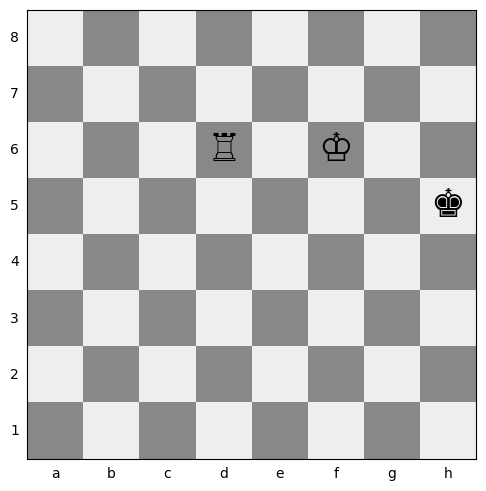

<Axes: >

In [4]:
plot_game(game)

In [5]:
states, actions, rewards, players, DTM = agent.sample_episode(fen)

In [6]:
print(actions[0])

2736


In [7]:
# Verify the episode data
print(f"Number of states: {len(states)}")
print(f"Number of actions: {len(actions)}")
print(f"Number of rewards: {len(rewards)}")
print(f"Number of players: {len(players)}")
print(f"DTM (Distance to Mate): {DTM}")
print(f"Total reward: {sum(rewards)}")
print(f"Players in episode: {players}")

Number of states: 100
Number of actions: 100
Number of rewards: 100
Number of players: 100
DTM (Distance to Mate): 50
Total reward: -1.99
Players in episode: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [13]:
actions_converted = [agent.idx_to_move[action] for action in actions]
print("Actions in UCI format:")
for action in actions_converted:
    print(action)

KeyError: -1

In [9]:
# run many times the sampling episode and obtain the ones with positive rewards,
# also save the positive episodes such that I can analyze them later

positive_episodes = []

for i in range(10000):
    states, actions, rewards, players, DTM = agent.sample_episode(fen)
    if sum(rewards) > 0:
        print(f"Episode {i+1}: Total reward = {sum(rewards)}")
        positive_episodes.append((states, actions, rewards, players, DTM))

# Analyze positive episodes
#for episode in positive_episodes:
    #states, actions, rewards, players, DTM = episode
    # Perform analysis on each positive episode

Episode 1663: Total reward = 998.0
Episode 2832: Total reward = 998.0
Episode 3073: Total reward = 998.0
Episode 3748: Total reward = 998.0
Episode 5815: Total reward = 998.0


In [10]:
len(positive_episodes)

5

In [34]:
positive_episodes[4]

(['8/8/3R1K2/7k/8/8/8/8 w - - 0 1',
  '8/8/5K2/7k/3R4/8/8/8 b - - 0 1',
  '8/8/5K1k/8/3R4/8/8/8 w - - 0 1'],
 [2736, 2503, 1731],
 [-1.0, -1.0, 1000.0],
 [1, 0, 1],
 3)

In [ ]:
states = positive_episodes[4][0]
actions = positive_episodes[4][1]
rewards = positive_episodes[4][2]
players = positive_episodes[4][3]
DTM = positive_episodes[4][4]

In [8]:
returns = agent.calculate_returns(rewards)
returns

[-0.20498570881712333,
 -0.20524811454434036,
 -0.20552433109930565,
 -0.20581508536769016,
 -0.20612114249230543,
 -0.20644330788663728,
 -0.20678242935435504,
 -0.20713939932037373,
 -0.20751515717934077,
 -0.20791069176772714,
 -0.20832704396602858,
 -0.20876530943792482,
 -0.20922664151360507,
 -0.20971225422484743,
 -0.2102234254998394,
 -0.21076150052614676,
 -0.2113278952906808,
 -0.2119241003059798,
 -0.2125516845326103,
 -0.21321229950801085,
 -0.21390768369264299,
 -0.21463966704488735,
 -0.21541017583672353,
 -0.2162212377228669,
 -0.21707498707670198,
 -0.21797367060705472,
 -0.2189196532705839,
 -0.21991542449535148,
 -0.22096360473194893,
 -0.22206695234941992,
 -0.22322837089412623,
 -0.2244509167306592,
 -0.22573780708490443,
 -0.22709242851042571,
 -0.2285183458004481,
 -0.23001931136889275,
 -0.23159927512515027,
 -0.23326239486857925,
 -0.23501304723008343,
 -0.23685583918956152,
 -0.23879562019953843,
 -0.24083749494688256,
 -0.24298683678619218,
 -0.245249301880202

In [9]:
from utils.fen_parsing import parse_fen

In [10]:
log_probs = []
episode_returns = []

for i, player in enumerate(players):
    if player == 0:  # White move (stored as 0 in our tracking)
        fen_tensor = parse_fen(states[i]).unsqueeze(0)
        legal_moves = agent.get_legal_move_indices_from_fen(states[i])  
        
        # Get log probabilities
        log_prob_dist = agent.policy.get_log_probs(fen_tensor, legal_moves)
        log_prob = log_prob_dist[0, actions[i]]
        
        log_probs.append(log_prob)
        episode_returns.append(returns[i])

In [11]:
import torch

In [12]:
log_probs_tensor = torch.stack(log_probs)
returns_tensor = torch.tensor(episode_returns, dtype=torch.float32)

In [14]:
loss = -torch.mean(log_probs_tensor * returns_tensor)
loss.item()

-0.6960431933403015

In [33]:
log_probs_tensor

tensor([0.], grad_fn=<StackBackward0>)

In [36]:
states[0]

'8/8/3R1K2/7k/8/8/8/8 w - - 0 1'

In [41]:
fen_tensor = parse_fen(states[0]).unsqueeze(0)
fen_tensor


tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0

In [52]:
legal_moves = agent.get_legal_move_indices_from_fen(states[0])
legal_moves

[2712,
 2720,
 2728,
 2736,
 2744,
 2749,
 2750,
 2751,
 2752,
 2759,
 2767,
 2871,
 2872,
 2879,
 2886,
 2887,
 2888]

In [55]:
log_prob_dist = agent.policy.get_log_probs(fen_tensor, legal_moves)
log_prob_dist[0, actions[0]]

tensor(-2.8843, grad_fn=<SelectBackward0>)

In [49]:
# Debug the get_log_probs issue
from utils.fen_parsing import parse_fen

# Get the first state from our episode
first_state = states[0]
print(f"First state FEN: {first_state}")

# Parse it to tensor
fen_tensor = parse_fen(first_state).unsqueeze(0)
print(f"FEN tensor shape: {fen_tensor.shape}")

# Get legal moves
legal_moves = agent.get_legal_move_indices_from_fen(first_state)
print(f"Legal moves: {legal_moves}")
print(f"Number of legal moves: {len(legal_moves)}")

# Check raw logits from the policy network
raw_logits = agent.policy.forward(fen_tensor)
print(f"Raw logits shape: {raw_logits.shape}")
print(f"Raw logits min: {raw_logits.min().item()}")
print(f"Raw logits max: {raw_logits.max().item()}")
print(f"Raw logits for legal moves: {[raw_logits[0, move].item() for move in legal_moves[:5]]}")

# Check what happens in get_log_probs
log_probs = agent.policy.get_log_probs(fen_tensor, legal_moves)
print(f"Log probs shape: {log_probs.shape}")
print(f"Log probs for legal moves: {[log_probs[0, move].item() for move in legal_moves[:5]]}")

First state FEN: 8/8/3R1K2/7k/8/8/8/8 w - - 0 1
FEN tensor shape: torch.Size([1, 8, 8, 12])
Legal moves: [2712, 2720, 2728, 2736, 2744, 2749, 2750, 2751, 2752, 2759, 2767, 2871, 2872, 2879, 2886, 2887, 2888]
Number of legal moves: 17
Raw logits shape: torch.Size([1, 4096])
Raw logits min: -0.1388198584318161
Raw logits max: 0.139855295419693
Raw logits for legal moves: [0.0023105964064598083, 0.03125470131635666, -0.003024696372449398, 0.032907500863075256, -0.0783950686454773]
Log probs shape: torch.Size([1, 4096])
Log probs for legal moves: [-2.8223683834075928, -2.80724835395813, -2.8002889156341553, -2.812004804611206, -2.8754661083221436]


In [50]:
# Test the fixed get_log_probs                                                                                
agent = REINFORCE()  # Reload with the fix                                                  
# Test with the same FEN                                                                                      
log_probs_fixed = agent.policy.get_log_probs(fen_tensor, legal_moves)                                         
print(f"Fixed log probs for legal moves: {[log_probs_fixed[0, move].item() for move in legal_moves[:5]]}")    
print(f"Sum of probabilities for legal moves: {torch.exp(log_probs_fixed[0, legal_moves]).sum().item()}")    
# Should be close to 1.0 and log probs should be reasonable (not -inf)

Fixed log probs for legal moves: [-2.758781671524048, -2.885833978652954, -2.795569896697998, -2.895465135574341, -2.8721792697906494]
Sum of probabilities for legal moves: 1.0
